In [1]:
from Solvers import adv_solver, span_solver, span_solver2, span_dual_relax
from Adversary import Adversary, Problem, to_str, visualize
import numpy as np
import matplotlib.pyplot as plt
import itertools
from Examples import exact_k, threshold_k
from ElementDistinctness import ED
from copy import deepcopy as copy
import scipy
import cvxpy as cp
import itertools
import matplotlib as mpl
mpl.rcParams['figure.dpi'] =200

In [2]:
class SpanProgram():
    def __init__(self, problem, I_dict, witnesses=None):
        self.witnesses = witnesses
        self.target = np.ones(problem.no_len)
        self.num_vects = np.sum([len(v) for i, v in I_dict.items()])
        self.ordered_I = [pair for pair in itertools.product(tuple(range(problem.n)), problem.alphabet)]
        self.I_to_mat = {}
        self.counter = 0
        self.vect_list = []
        self.ticks = []
        self.I_dict = I_dict
        self.problem = problem
        for pair, v_set in I_dict.items():
            self.ticks.append(self.counter)
            self.I_to_mat[pair] = list(range(self.counter, self.counter + len(v_set)))
            self.counter += len(v_set)
            for vect in v_set:
                self.vect_list.append(vect)
            # self.vect_list.append(*v_set)
        self.A = np.array(self.vect_list).T 
    
    def get_activated_A(self, x):
        activated_A = np.zeros(self.A.shape)
        for i in range(len(x)):
            interval = self.I_to_mat[(i, x[i])]
            activated_A[:, interval] = self.A[:, interval]
        return activated_A
        
    def apply(x, witness):
        return get_activated_A(x) @ witness
    
    def visualize_A(self):
        x_ticks = []
        for i in self.ordered_I:
            x_ticks.append(i)
            x_ticks += [''] * (len(self.I_dict[i])-1)
        visualize(self.A, (x_ticks, [to_str(no) for no in self.problem.no_instances]))
    
    def visualize_witnesses(self):
        y_ticks = []
        for i in self.ordered_I:
            y_ticks.append(i)
            y_ticks += [''] * (len(self.I_dict[i])-1)
        print('y:',len(y_ticks), self.witnesses[0].shape)
        print('x:',len(self.problem.yes_instances), len(self.witnesses))
        
        visualize(np.array(self.witnesses).T, ([to_str(yes) for yes in self.problem.yes_instances], y_ticks))

[(0, 1, 2), (0, 2, 1), (1, 0, 2), (1, 2, 0), (2, 0, 1), (2, 1, 0)]
18 6 24
after
after2
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Aug 25 06:57:02 PM: Your problem has 133 variables, 1 constraints, and 0 parameters.
(CVXPY) Aug 25 06:57:02 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 25 06:57:02 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 25 06:57:02 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Aug 25 06:57:02 PM: Compiling problem (target solver=MOSEK).
(CVXPY

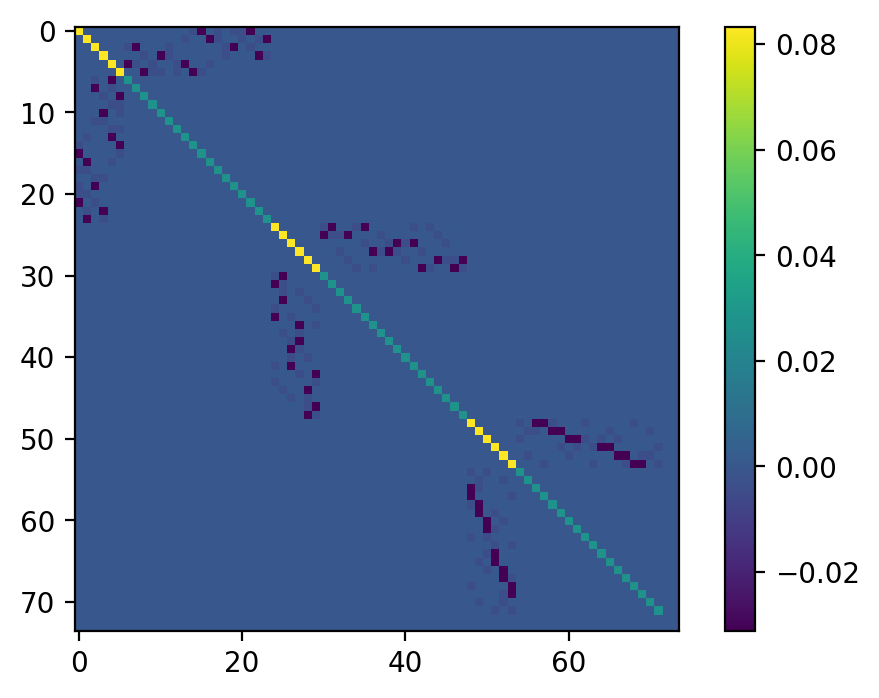

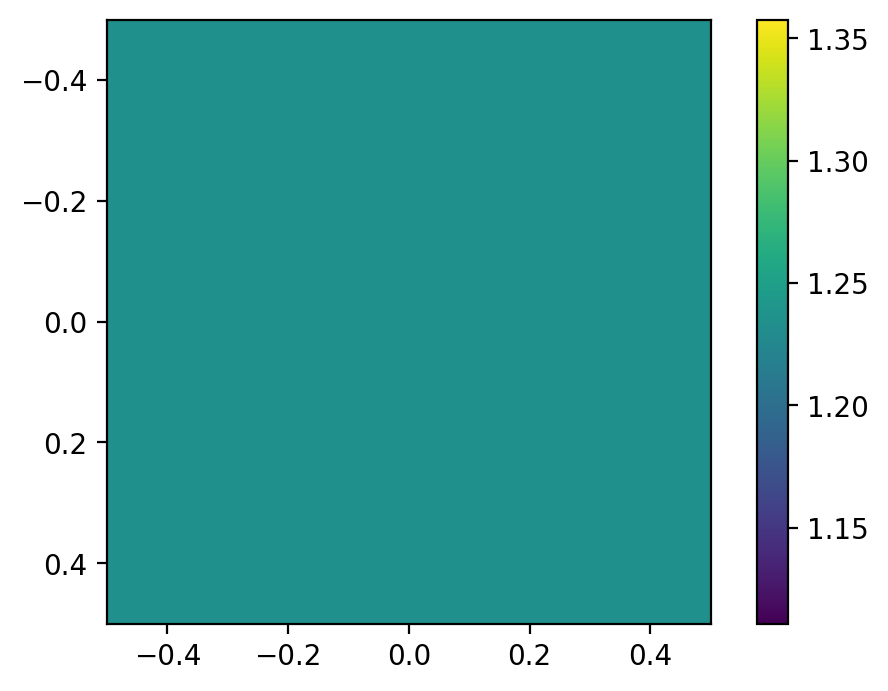

In [7]:
diffs = []
prob = ED(3)
print(prob.yes_len, prob.no_len, prob.len)
target = np.zeros(prob.yes_len)
# target[0] = 1
small, big, T  = span_dual_relax(prob,1)
# v, X = span_solver(prob, 3)
print(big)
plt.imshow(big)
plt.colorbar()
plt.show()
# plt.imshow(X)
# plt.colorbar()
# plt.show()
# plt.imshow(Y)
plt.imshow(T)
# print(np.max(np.abs(Y)))
plt.colorbar()
plt.show()
# plt.imshow(X_ieq)
# plt.colorbar()
# plt.show()
# plt.imshow(X_eq-X_ieq)
# plt.colorbar()
# plt.show()


In [12]:
def rand_function(n, alpha='01'):
    yes = []
    no = []
    for s in itertools.product(*[alpha]*n):
        if np.random.randint(2):
            yes.append(s)
        else:
            no.append(s)
    return Problem(no, yes)

In [13]:
def get_cholesky_fact(A, eps_pow=15):
    for i in range(eps_pow,1,-1):
        print(i)
        try:
            curr_A = A + 10**-i * np.eye(A.shape[0])
            return np.round(scipy.linalg.cholesky(curr_A), i-1)
        except:
            pass
def decompose_cholesky(L, problem):
    # print(problem.no_len)?
    partials = []
    for i in range(problem.n):
        full_partial = L[i * problem.len: (i+1)* problem.len, i * problem.len: (i+1)* problem.len]
        nonzero_columns = []
        for j in range(full_partial.shape[1]):
            v = full_partial[:, j]
            if np.linalg.norm(v) > 10**-3:
                # print('j', j)
                nonzero_columns.append(v)
        partials.append(np.array(nonzero_columns).T)
    return partials

def span_from_decomp(partials, problem):
    I = {}
    for j, b in itertools.product(range(problem.n), problem.alphabet):
        I[(j, b)] = []
        for i in range(partials[j].shape[1]):
            v = np.zeros(problem.no_len)
            for no_index in range(problem.no_len):
                no = problem.no_instances[no_index]
                if no[j] != b:
                    # print(j, i, no_index)
                    v[no_index] = partials[j][no_index, i]
            I[(j,b)].append(v)
    witnesses = []
    for yes_index in range(problem.yes_len):
        yes = problem.yes_instances[yes_index]
        w = []
        for (j, b), vects in I.items():
            if yes[j] != b:
                num_zeros = np.sum(v.shape[0] for v in vects)
                w += [0] * partials[j].shape[1]
            else:
                w += list(partials[j][problem.no_len + yes_index, :])
        # print(w)
        witnesses.append(np.array(w))
        
    return SpanProgram(problem, I, witnesses)
                
X2 = np.round(X, 7)
print('rank', np.linalg.matrix_rank(X2))
# print(X)
L = get_cholesky_fact(X2)
# U, S, V = np.linalg.svd(L)
# plt.imshow(L)
# plt.show()
# plt.imshow(U)
# plt.show()
# plt.imshow(V)
# plt.show()
partials = decompose_cholesky(L.T, prob)
# print(partials[0].shape)
# plt.imshow(L.T)
# plt.show()
# plt.show()
# print(sp.A)
# for partial in partials:
    # plt.imshow(partial)
    # plt.colorbar()
    # plt.show()
# plt.imshow()
sp = span_from_decomp(partials, prob)
print('yes', prob.yes_len,'no',  prob.no_len)
# plt.imshow()
print(set(1/np.max(sp.A) * sp.A.flatten()))
print(set(1/np.max(np.array(sp.witnesses).flatten()) *np.array(sp.witnesses).flatten()))
# plt.imshow(np.array(sp.witnesses).T)
# plt.colorbar()kk
# plt.show()
sp.visualize_A()
sp.visualize_witnesses()
print(sp.A@sp.witnesses[-1].T)
# print(np.array(sp.witnesses).T)
# plt.imshow(np.array(sp.witnesses) - sp.A)
# plt.colorbar()

rank 6
15
14
13
12
11
10
9
8
7
6
5
4
3
2


AttributeError: 'NoneType' object has no attribute 'T'

In [2]:
print(np.array([1,2,3]).shape)

NameError: name 'np' is not defined

In [3]:
print(v, np.max([X[i][i] for i in range(X.shape[0])]))
print('norm', np.linalg.norm(X, 2))
print('len', X.shape[0])
print('rank', np.linalg.matrix_rank(X2), np.linalg.matrix_rank(X))
print(np.trace(X2))
evals, evects = np.linalg.eig(X2[:6, :6])
visualize(evects.real, [prob.yes_instances + prob.no_instances] * 2)

NameError: name 'v' is not defined

In [3]:
print('boop1')

boop1


In [7]:
input('bop')
def ez_space_vects(problem):
    vects = {}
    for j in range(problem.n):
        print('j', j)
        for b in problem.alphabet:
            vects[(j,b)] = []
            v = np.zeros(problem.no_len)
            for no_index in range(problem.no_len):
                no = problem.no_instances[no_index]
                if no[j] != b:
                    v[no_index] = 1
                    
            vects[(j,b)].append(v)
    return SpanProgram( problem, vects)
input('boop')
prob = threshold_k(3, 2)
print(prob)
sp = ez_space_vects(prob)
# sp.A[0][1] = -1

KeyboardInterrupt: Interrupted by user

In [ ]:
def find_opt_witness(span_program):
    A = span_program.A
    problem = span_program.problem
    witness_vars = [cp.Variable(A.shape[1]) for _ in range(span_program.problem.yes_len)]
    constraints = [span_program.get_activated_A(x) @ witness_vars[problem.yes_instance_to_index[x]] == np.ones(problem.no_len) for x in span_program.problem.yes_instances]
    for x in problem.yes_instances:
        w = witness_vars[problem.yes_instance_to_index[x]]
        for i in range(len(x)):       
            for b in problem.alphabet:
                if x[i] != b:
                    constraints += [w[j] == 0 for j in span_program.I_to_mat[(i, b)]]
    opt_func = cp.Minimize(cp.max(cp.vstack([cp.norm(w, 2) for w in witness_vars])))
    opt_prob = cp.Problem(opt_func, constraints)
    opt_prob.solve(solver='SCS', verbose=True)
    return opt_prob.value, np.array([w.value for w in witness_vars]).T

v, W = find_opt_witness(sp)
print(W)
print(sp.A)
sp.visualize_A()
sp.witnesses = W
sp.visualize_witnesses()

In [23]:
print(sp.A @W )

[[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
  1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
 [1. 1. 1.

In [60]:

def special_span_sdp(problem, d):
    t = cp.Variable()
    vects = {z: [cp.Variable(d) for j in range(problem.n)] for z in problem.instances}
    constraints = []
    for yes, no in itertools.product(problem.yes_instances, problem.no_instances):
        constraints.append(cp.sum(
            [cp.scalar_product(vects[yes][j], vects[no][j]) for j in range(problem.n) if yes[j] != no[j]]) == 1
        )
    
    opt_func = cp.max(cp.vstack([
        cp.sum([vects[z][j]**2 for j in range(problem.n)])
        for z in problem.instances])
    )
    
    opt_prob = cp.Problem(cp.Minimize(opt_func), constraints)
    opt_prob.solve()
    return opt_prob.value, [[vects[z][j].value for z in problem.instances] for j in range(problem.n)]
    
def test_sdp():
    x = cp.Variable(10)
    y = cp.Variable(10)
    z = cp.Variable(10)
    w = cp.Variable(10)
    constraints = [x >= 2, y >= 3, w >= 4, z >= 5]
    opt_prob = cp.Problem(cp.Minimize(x @ y), constraints)
    opt_prob.solve()
    # return opt_prob.valuex.value, y.value
prob = threshold_k(3, 2)

[[1.  0.5 0.5 0.5 0.5 0.5]
 [0.5 1.  0.5 1.  0.5 1. ]
 [0.5 0.5 1.  0.5 1.  1. ]
 [0.5 1.  0.5 1.  0.5 1. ]
 [0.5 0.5 1.  0.5 1.  1. ]
 [0.5 1.  1.  1.  1.  1. ]]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
[-0.3077061  -0.3077061   0.          0.78820544 -0.3077061  -0.3077061 ]


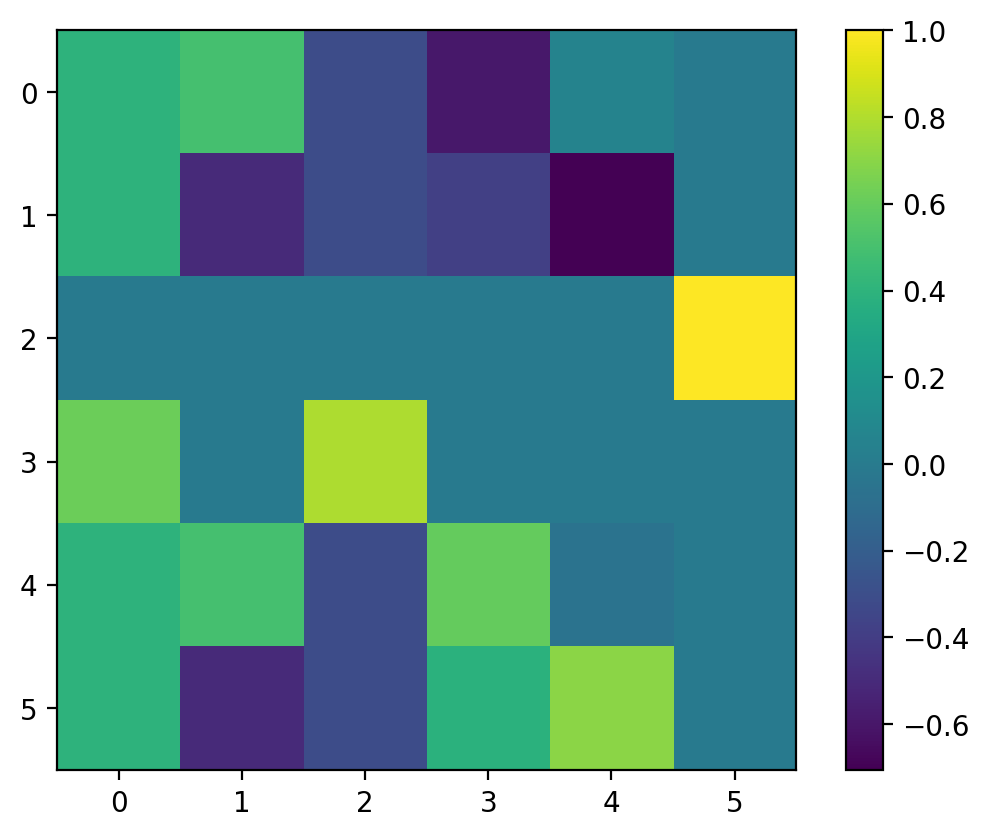

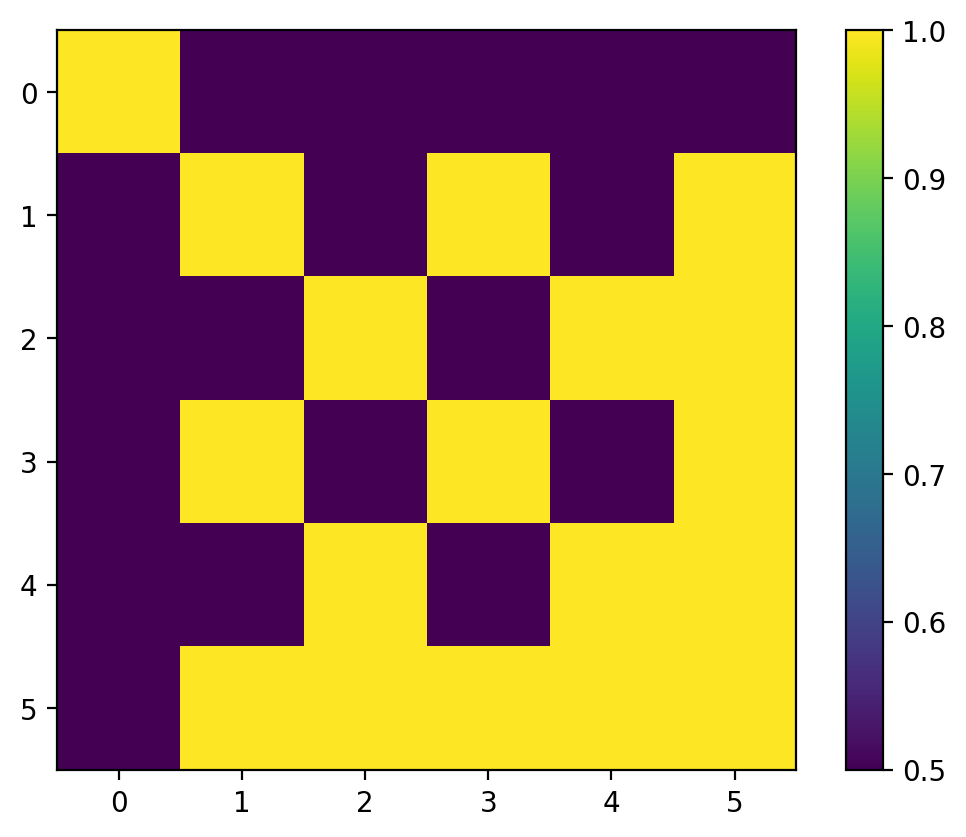

[ 4.58238560e+00  6.64077068e-01 -2.46462670e-01  1.00000000e+00
 -3.77727502e-17  8.86238777e-17]
[[1.  0.5 0.5 0.5 0.5 0.5]
 [0.5 1.  0.5 1.  0.5 1. ]
 [0.5 0.5 1.  0.5 1.  1. ]
 [0.5 1.  0.5 1.  0.5 1. ]
 [0.5 0.5 1.  0.5 1.  1. ]
 [0.5 1.  1.  1.  1.  1. ]]
[[1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]
 [1. 1. 1. 1. 1. 1.]]
0
[[1.  0.5 0.5 0.5 0.5 0.5]
 [0.5 1.  0.5 1.  0.5 1. ]
 [0.5 0.5 1.  0.5 1.  1. ]
 [0.5 1.  0.5 1.  0.5 1. ]
 [0.5 0.5 1.  0.5 1.  1. ]
 [0.5 1.  1.  1.  1.  1. ]]


LinAlgError: Matrix is not positive definite

In [39]:
def dist(x,y):
    return len([j for j in range(len(x)) if x[j]==1 and y[j]==0])
def get_A(problem, j):
    A = np.zeros((problem.len, problem.len))
    for i in range(problem.len):
        for p in range(problem.len):
            inst1 = problem.instances[i]
            inst2 = problem.instances[p]
            if i != p:
                # print(inst1, inst2, k)
                v = len([l for l in range(n) if l != j and inst1[l] == 1 and inst2[l] == 1])

                A[i,p] = v
            else:
                A[i,p] = k-1
    return A

def get_Xj(problem, j):
    n = problem.n
    k = dist(problem.yes_instances[0], [0]*n)
    B = np.zeros((problem.len, problem.len))
    D = np.ones((problem.len, problem.len))
    for i in range(problem.len):
        for p in range(problem.len):
            inst1 = problem.instances[i]
            inst2 = problem.instances[p]
            if i != p:
                # print(inst1, inst2, k)
                v = len([l for l in range(n) if l != j and inst1[l] == 1 and inst2[l] == 1])
                
                B[i,p] = 1/(k-v)
            else:
                B[i,p] = 1
    
    for yes1 in problem.yes_instances:
        yes_index1 = problem.instance_to_index[yes1]
        for yes2 in problem.yes_instances:
            if yes1 != yes2:
                yes_index2 = problem.instance_to_index[yes2]
                D[yes_index1, yes_index2] = np.sqrt((n-k+1)/k) 
        
        # for no in problem.no_instances:
        #     no_index = problem.instance_to_index[no]
        #     if no[j] == 0 or (no[j]==1 and yes1[j]==1):
        #         B[yes_index1, no_index] = 0
        #         B[no_index, yes_index1] = 0
        
    for no1 in problem.no_instances:
        no_index1 = problem.instance_to_index[no1]
        for no2 in problem.no_instances:
            if no1 != no2:
                no_index2 = problem.instance_to_index[no2]
                D[no_index1, no_index2] = np.sqrt(k/(n-k+1))
    
    
    print(B)
    print(D)
    return np.multiply(B, D)
n=3
k=2
prob = threshold_k(n, k)
Xj = get_Xj(prob, 0)
A = get_A(prob, 1)
vals, vects = np.linalg.eig(A)
print(vects[:, 2])
plt.imshow(np.array(vects))
plt.colorbar()
plt.show()
L = np.linalg.cholesky(A+2*np.eye(prob.len))
plt.imshow(Xj)
plt.colorbar()
plt.show()
print(np.linalg.eigvals(Xj))
X = np.zeros((n * prob.len, n * prob.len))



for i in range(n):
    X= get_Xj(prob, i)
    print(i)
    print(X)
    X[i*prob.len: (i+1)*prob.len, i*prob.len: (i+1)*prob.len] = Xj
    print(np.linalg.cholesky(Xj+.01 * np.eye(prob.len)))
    

plt.imshow(np.linalg.cholesky(X+.001 * np.eye(n * prob.len)))

In [19]:
X2 = X
# print(X)
L = get_cholesky_fact(X2)
print(L)
partials = decompose_cholesky(L.T, prob)
# print(partials[0].shape)
# plt.imshow(L.T)
# plt.show()
# print(sp.A)
# for partial in partials:
    # plt.imshow(partial)
    # plt.colorbar()
    # plt.show()
# plt.imshow()
sp = span_from_decomp(partials, prob)
# plt.imshow()
print(set(sp.A.flatten()))
plt.imshow(np.array(sp.witnesses).T)
plt.colorbar()
plt.show()
sp.visualize_A()
sp.visualize_witnesses()
print(np.array(sp.witnesses).T)

15
14
13
12
11
10
9
8
7
6
5
4
3
2
None


AttributeError: 'NoneType' object has no attribute 'T'

In [6]:
list(itertools.combinations([(1,2), (3,4)], 2))

TypeError: combinations() takes at most 2 arguments (3 given)